In [8]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")
data_dir = "../"

# Reaction Time on SLO Breach

This data visualizes the reaction time of the system in case of an SLO-Breach. To collect this data three different methods were used to simulate a breach. For deployments to AWS Lambda, the breach was simulated by changing the limit of the latency slo to 0. To simulate the breach on OpenFaaS resources the benchmark application ran the linux tool "stress" for two cpu cores, which increased the cpu utilisation above the limit of the selected ensemble. On K8S resources a similar approach was applied. The benchmark tool started up a pod where the linux tool "stress" has been executed to increase the current cpu utilisation. Following setups have been tested:
- Lambda: 
      - function 1 on resource 14 with 1 and 4 concurrent deployments
      - function 1, 2, 3 on resources 14, 15 with 1 and 4 concurrent deployments
- K8S:
      - service 1 on resource 7 with 1 and 4 concurrent deployments
      - service 1 on resource 7, 8, 9 with 1 and 4 concurrent deployments
- OpenFaaS:
      - function 1 on resource 2 with 1 and 4 concurrent deployments
      - function 1 ond resource 1, 2, 3 with 1 and 4 concurrent deployments

The original data can be found in [reaction_time](../reaction_time)

In [9]:
ru_dir = os.path.join(data_dir, "reaction_time")

In [10]:
df_timestamps = pd.DataFrame()
df_alert = pd.DataFrame()

for root, dirs, files in os.walk(ru_dir):
       for subdir in dirs:
              curr_ru_dir = os.path.join(root, subdir)               
              start_timestamp = 0
              for file_path in glob.glob(curr_ru_dir + "/*.csv"):
                     df = pd.read_csv(file_path)
                     df["type"] = subdir + file_path.split(curr_ru_dir)[1].split('_')[0]
                     concurrent_deployments = file_path.split(curr_ru_dir)[1].split('_')[1].split('.')[0]
                     
                     df['concurrent_deployments'] = int(concurrent_deployments)
              
                     if file_path.endswith('_alert.csv'):
                            df["timestamp"] = df["timestamp"] - start_timestamp
                            df = df.drop(df[df["timestamp"] < 0].index)
                            df_alert = pd.concat([df_alert, df], ignore_index=True)
                     else:
                            start_timestamp = df["start"].min()
                            finish_timestamp = df["end"].max()
                            df["start"] = df["start"] - start_timestamp
                            df["end"] = df["end"] - start_timestamp
                            df_timestamps = pd.concat([df_timestamps, df], ignore_index=True)

In [11]:
df_timestamps

,id,start,end,type,concurrent_deployments
0,0,0,20045,k8s\multiple,1
1,1,114501,134531,k8s\multiple,1
2,2,231944,251974,k8s\multiple,1
3,0,0,20029,k8s\single,1
4,1,91420,111453,k8s\single,1
5,2,174811,194846,k8s\single,1
6,0,0,20029,k8s\single,4
7,1,126652,146681,k8s\single,4
8,2,240117,260146,k8s\single,4
9,0,0,20038,lambda\multiple,1


In [12]:
df_alert

,timestamp,resource,metric,value,type,concurrent_deployments,deployment
0,19229,7,cpu%,31.573440,k8s\multiple,1,NaN
1,24229,7,cpu%,31.573440,k8s\multiple,1,NaN
2,30229,7,cpu%,31.573440,k8s\multiple,1,NaN
3,36229,7,cpu%,35.603341,k8s\multiple,1,NaN
4,41229,7,cpu%,35.603341,k8s\multiple,1,NaN
...,...,...,...,...,...,...,...
425,63048,2,cpu%,56.600000,openfaas\single,4,4.0
426,84048,2,cpu%,27.700000,openfaas\single,4,4.0
427,90048,2,cpu%,55.900000,openfaas\single,4,4.0
428,95048,2,cpu%,53.450000,openfaas\single,4,4.0


In [13]:
# Find the closest timestamp in df_alert for each start value in df_timestamps
closest_timestamps = []

for index, row in df_timestamps.iterrows():
       start_value = row['start']
       type_value = row['type']
       concurrent_value = row['concurrent_deployments']

       # Filter df_alert based on the 'type' and 'concurrent_deployments' columns and create a copy
       filtered_alert = df_alert[(df_alert['type'] == type_value) & (df_alert['concurrent_deployments'] == concurrent_value)].copy()

       # Find the closest timestamp in filtered_alert
       closest_timestamp = filtered_alert.loc[filtered_alert['timestamp'].sub(start_value).abs().idxmin()]

       # Calculate the difference between the timestamps
       difference = abs(closest_timestamp['timestamp'] - start_value)

       # Store the difference in a new column in the original DataFrame
       df_timestamps.at[index, 'reaction_time'] = difference

# Print the DataFrame with closest timestamps and differences
df_timestamps[df_timestamps['type'] == 'lambda\\single']

,id,start,end,type,concurrent_deployments,reaction_time
15,0,0,20039,lambda\single,1,1021.0
16,1,44082,64324,lambda\single,1,3939.0
17,2,80362,100604,lambda\single,1,2659.0
18,0,0,20057,lambda\single,4,1291.0
19,1,34096,54132,lambda\single,4,805.0
20,2,74169,94205,lambda\single,4,2122.0


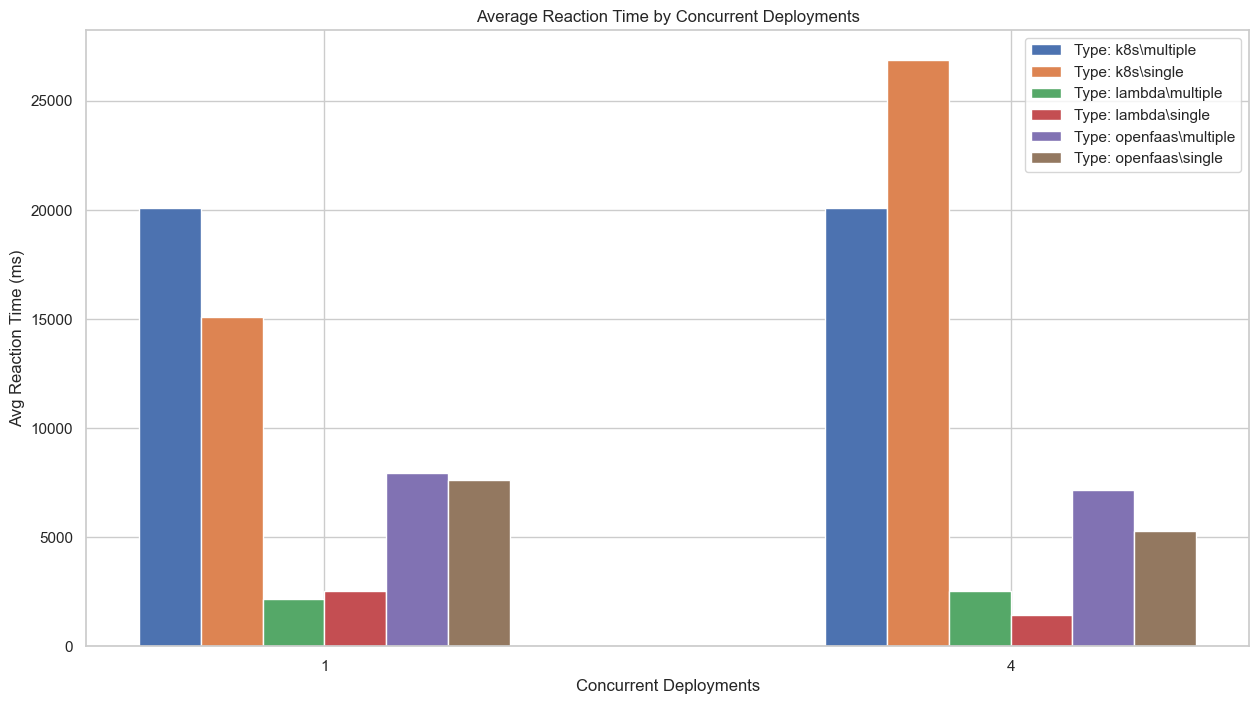

In [14]:
grouped = df_timestamps.groupby(['type', 'concurrent_deployments'])['reaction_time'].mean().reset_index()

# Determine the unique types and concurrent deployments
unique_types = grouped['type'].unique()
unique_concurrent_deployments = grouped['concurrent_deployments'].unique()

# Calculate the width of each bar
bar_width = 0.09

# Create a combined plot
plt.figure(figsize=(15, 8))

# Iterate over unique types to plot the average reaction time as bars
for i, type_value in enumerate(unique_types):
       # Filter the grouped DataFrame for the current type
       filtered_grouped = grouped[grouped['type'] == type_value]

       # Calculate the position of the bars for the current type
       bar_positions = [j + i * bar_width for j in range(len(unique_concurrent_deployments))]

       # Plot the average reaction time for the current type
       plt.bar(bar_positions, filtered_grouped['reaction_time'], width=bar_width, label=f'Type: {type_value}')

# Set labels and title
plt.xlabel('Concurrent Deployments')
plt.ylabel('Avg Reaction Time (ms)')
plt.title('Average Reaction Time by Concurrent Deployments')

# Set x-axis tick positions and labels
plt.xticks([j + (len(unique_types) - 1) * bar_width / 2 for j in range(len(unique_concurrent_deployments))],
           unique_concurrent_deployments)

# Add legend
plt.legend()

# Show the plot
plt.show()